# Settings

In [20]:
import pandas as pd
import numpy as np

# 0. Bigram Model (Chapter 3)

In [6]:
class Bigram:
    def __init__(self):
        # Pseudowords
        self.pseudo_init = '<s>'; self.pseudo_termin = '</s>'
        self.corpus_sequence = []
        self.token_count = {self.pseudo_init:0, self.pseudo_termin:0}
        self.bigram_count = {self.pseudo_init:{self.pseudo_init:0, self.pseudo_termin:0}, 
                             self.pseudo_termin:{self.pseudo_init:0, self.pseudo_termin:0}}

    """ 
        Preprocessing
            - preprocess any paragraph into a sequence of tokens
    """
    def preprocess_corpus(self, paragraph):
        corpus_sequence = []
        for sentence in (paragraph.split('.')): # Divide by sentences
            if (sentence == '') : corpus_sequence.append(self.pseudo_termin); break # Ignore the void sentence after the last period
            corpus_sequence.append(self.pseudo_init) # Add a pseudo_init before every sentence.
            for word in ((sentence.strip()).split(' ')): # Remove spaces and divide by words
                corpus_sequence.append(word) # Add all word to the sequence
            corpus_sequence.append(self.pseudo_termin) # Add a pseudo_termin after every sentence
        return corpus_sequence[:-1] # In case the given paragraph doesn't end with a full sentence
    
    def preprocess_target(self, target):
        target_sequence = []
        for token in target.split(' '):
            target_sequence.append(token)
        return target_sequence
                
                
            
    """
        Construct Bigram Count
            - from the corpus sequence, construct bigram count table
            - self.corpus_sequence should have been constructed in advance
    """
    def count_bigram(self):
        prev_token = self.pseudo_init; self.token_count[self.pseudo_init] += 1;
        for token in self.corpus_sequence[1:]:
            if token in self.token_count:
                self.token_count[token] += 1
            else: 
                self.token_count[token] = 1
                # Add a new row(of token) to the bigram_count graph
                self.bigram_count[token] = {token:0}
                for existing_token in self.bigram_count.keys():
                    self.bigram_count[token][existing_token] = 0
                    # Add a new column to the bigram_count graph
                    self.bigram_count[existing_token][token] = 0
            self.bigram_count[prev_token][token] += 1
            prev_token = token
    
    def display_bigram_count(self):
        display(pd.DataFrame(self.bigram_count).transpose())
    
    def train(self, corpus, show_table=False):
        self.corpus_sequence = self.preprocess_corpus(corpus)
        self.count_bigram()
        if (show_table == True):
            self.display_bigram_count()
    
    def calculate_bigram(self, target):
        # 1. Input Processing
        target_sequence = self.preprocess_target(target)
        
        # 2. Bigram Count
        #V = len(self.token_count.keys()) # Number of tokens (including pseudowords)
        
        n = len(target_sequence)
        
        p_total = 1
        for k in range(1,n):
            w_k = target_sequence[k]; w_kminus1 = target_sequence[k-1]
            p_k_given_kminus1 = self.bigram_count[w_kminus1][w_k] / self.token_count[w_kminus1]
            p_total *= p_k_given_kminus1
        
        return p_total

## 0.1 Train

In [7]:
corpus = "I am Sam. Sam I am. I do not like green eggs and ham."

bigram_model = Bigram()
bigram_model.train(corpus, show_table=True)

,<s>,</s>,I,am,Sam,do,not,like,green,eggs,and,ham
<s>,0,0,2,0,1,0,0,0,0,0,0,0
</s>,2,0,0,0,0,0,0,0,0,0,0,0
I,0,0,0,2,0,1,0,0,0,0,0,0
am,0,1,0,0,1,0,0,0,0,0,0,0
Sam,0,1,1,0,0,0,0,0,0,0,0,0
do,0,0,0,0,0,0,1,0,0,0,0,0
not,0,0,0,0,0,0,0,1,0,0,0,0
like,0,0,0,0,0,0,0,0,1,0,0,0
green,0,0,0,0,0,0,0,0,0,1,0,0
eggs,0,0,0,0,0,0,0,0,0,0,1,0


## 0.2 Test

In [9]:
targets = ["<s> I", "<s> Sam", "I am",
           "Sam </s>", "am Sam", "I do"]

for target in targets:
    print("P(" + target.split()[-1] + "|" + target.split()[0] + ") = " + str(round(bigram_model.calculate_bigram(target),2)))

P(I|<s>) = 0.67
P(Sam|<s>) = 0.33
P(am|I) = 0.67
P(</s>|Sam) = 0.5
P(Sam|am) = 0.5
P(do|I) = 0.33


# 1. Naive Bayes Classifier (Chapter 4)

In [175]:
class NaiveBayes:
    def __init__(self):
        import pandas as pd; import numpy as np; import math
        self.classes = set(); self.features = set()
        self.class_cnt = {}; self.feature_cnt = {}
        self.data_cnt = None; self.X_shape = None;
        
    def fit(self, X_train, y_train):
        self._count(X_train, y_train)
    
    def predict(self, X_test):
        # 0. Validate Input
        if (X_test.shape[1:] != self.X_shape):
            raise Exception("Match the data size of X_test")
        y_predict = []
        for X in X_test:
            y_predict.append(self._predict_single(X))
        return y_predict
    
    def _predict_single(self, X):
        probability = {}
        for label in self.classes:
            probability[label] = self._log_probability(X, label)
        return max(probability, key=probability.get)
    
    """
        Count the number of..
        
        1. Classes throughout the whole dataset
            - update self.class_cnt
        
        2. Feature occurence per class
            - update self.feature_cnt
    """
    def _count(self, X_train, y_train):
        # 0. Validate Input
        self.data_cnt = len(y_train);
        if (len(X_train) != self.data_cnt): 
            raise Exception("Match the data size of X_train and y_train")
        else:
            self.X_shape = X_train.shape[1:]
        
        for i in range(self.data_cnt):
            X = X_train[i]; y = y_train[i]
            
            ### [Update Class Count] ###################################################
            
            # 1. Check if a new class appears
            if (y not in self.classes):
                # 1.1 Add the class to class set and self.class_cnt
                self.classes.add(y) 
                self.class_cnt[y] = 0
                # 1.2 Create a column for the class in count table
                self.feature_cnt[y] = dict(zip(list(self.features), np.zeros(len(self.features), dtype=int))) 
            
            # 2. Update the class count
            self.class_cnt[y] += 1
            
            ############################################################################
            
            ### [Update Feature Count] #################################################
            
            for x_i in X:
                # 1. Check if a new feature appears
                if (x_i not in self.features):
                    # 1.1 Add the feature to the feature set
                    self.features.add(x_i)
                    # 1.2 Add a row for the feature in count table
                    for _class in self.feature_cnt.keys():
                        self.feature_cnt[_class][x_i] = 0
                        
                # 2. Update the feature count
                self.feature_cnt[y][x_i] += 1
            
            ############################################################################
        return
    
    """
        Compute P(X|y)
        
        1. term1: P(y)
        2. term2: P(X|y) -> with Laplace Smoothing
            
    """
    def _log_probability(self, X, y):
        term1 = math.log(self.class_cnt[y] / self.data_cnt, 10)
        
        term2 = 0
        features_sum = sum(self.feature_cnt[y].values()) + len(self.features)
        for x_i in X:
            try:
                term2 += math.log(self.feature_cnt[y][x_i] + 1, 10)
            except:
                term2 = 0
        
        return term1 + term2

In [176]:
X_train = np.array([["A", "B", "C"], ["A", "B", "B"], ["D", "F", "A"], ["C", "B", "B"]])
y_train = np.array(["Pass", "Pass", "Fail", "Fail"])

X_test1 = np.array([["A", "C", "B"],
                    ["A", "C", "X"],  # Unseen data -> smoothed by Laplace
                    ["F", "D", "B"],
                    ["X", "Y", "Z"]]) # Unseen data -> smoothed by Laplace

In [177]:
classifier = NaiveBayes()
classifier.fit(X_train, y_train)

classifier.predict(X_test1)

['Pass', 'Fail', 'Fail', 'Fail']

# 2. Softmax Regression Classifier (Chapter 5)

## 2.1 Base Model

In [435]:
class LogisticRegressionBase(object):
    def __init__(self):
        import numpy as np;
        self.n_labels = None
        self.X_size = None
        self.weights = None; self.biases = None
    
    """
        Training Data
            - y_train: An array of one-hot encoded vectors
            - lr: learning rate
    """
    def fit(self, X_train, y_train, lr=0.1):
        # 0. Validate input
        if (len(X_train) != len(y_train)): raise Exception("Match the data shape of X_train and y_train")
        self.X_size = len(X_train[0])
        self.n_labels = len(y_train[0])
        
        # 1. Assign random weights/biases
        std=1e-4 # standard deviation
        self.weights = std * np.random.randn(self.n_labels, self.X_size) # an array whose size is (n_features, n_classes)
        self.biases = std * np.random.randn(self.n_labels) # an array of length n_classes
        
        # 2. Update
        for i in range(len(y_train)): # loop over the train data
            loss, w_jacobian, b_jacobian = self.softmax_loss(X_train[i], y_train[i])
            self.gradient_descent(w_jacobian, b_jacobian, lr)
            print("Epoch " + str(i) + "\a:\a (loss: " + str(loss) + ")")
    
    def predict(self, X):
        # 0. Validate input
        if (X.shape[0] != self.X_size): raise Exception("Match data shape of X_test: " + str(self.X_size))
        
        # 1. Predict Label(class)
        prob = np.dot(self.weights, X) + self.biases
        label = np.argmax(prob)
        
        # 2. Convert the label into a one-hot encoded vector
        label_vector = np.zeros(self.n_labels, dtype=int); label_vector[label] = 1
        return label_vector
        
        
        
    def softmax_loss(self, X, y):
        """
            Compute the Loss and Gradients for a binary classifier
            Return:
                - Loss
                - Gradient
        """
        # 1. Compute the summ for softmax
        summ = 0
        for k in range(self.n_labels): # loop through the classes
            w_k = self.weights[k]; b_k = self.biases[k]
            summ += np.exp(np.dot(w_k, X) + b_k)
        
        # 2. Update the gradient matrixes, and calculate the loss
        loss = 0; 
        w_jacobian = np.zeros(self.weights.shape); b_jacobian = np.zeros(self.biases.shape)
        for k in range(self.n_labels):
            w_k = self.weights[k]; b_k = self.biases[k]
            softmax = (np.dot(w_k, X) + b_k) / summ # softmax
            gradient = softmax - y[k]
            for i in range(self.X_size):
                w_jacobian[k][i] = gradient * X[i]
            b_jacobian[k] = gradient
            
            # Loss -= softmax for the correct class
            if (y[k] == 1): loss -= softmax;
        
        return loss, w_jacobian, b_jacobian
    
    
    def gradient_descent(self, w_jacobian, b_jacobian, lr):
        """
            Update the weights and biases
        """
        self.weights -= lr * w_jacobian
        self.biases -= lr * b_jacobian

## Test

### 1) Create Training Data

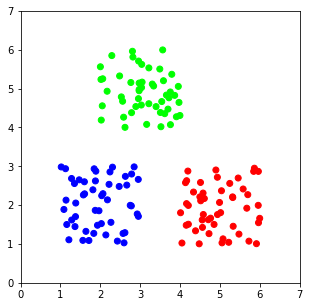

In [427]:
import matplotlib.pyplot as plt

X_train = []; y_train = []

# Create random data points
data_per_label = 50
labels = [[0,0,1], [0,1,0], [1,0,0]]; centroids = [(2,2), (3,5), (5,2)]
for i in range(len(labels)):
    xs = centroids[i][0] + (np.random.random_sample((data_per_label,)) - 0.5) * 2
    ys = centroids[i][1] + (np.random.random_sample((data_per_label,)) - 0.5) * 2
    X_train += list(zip(xs, ys))
    y_train += [labels[i] for j in range(data_per_label)]
    
# Shuffle
shuffle = list(zip(X_train, y_train)); np.random.shuffle(shuffle)
X_train = list(map(lambda pair: pair[0], shuffle))
y_train = list(map(lambda pair: pair[1], shuffle))

plt.figure(figsize = (5,5))
plt.scatter([point[0] for point in X_train], [point[1] for point in X_train], c=y_train, label=y_train)
plt.xlim([0, 7]); plt.ylim([0, 7])
plt.show()

### Train

In [434]:
classifier = LogisticRegressionBase()
classifier.fit(X_train, y_train)

Epoch 0: (loss: 4.4105381033849416e-05)
Epoch 1: (loss: -8.603652441817992e-06)
Epoch 2: (loss: -0.13534745400388967)
Epoch 3: (loss: -0.06861055854746033)
Epoch 4: (loss: -0.07971829758389916)
Epoch 5: (loss: -2.9189777685678223e-06)
Epoch 6: (loss: -0.03459009556946306)
Epoch 7: (loss: -0.017180303353278546)
Epoch 8: (loss: -0.07128848191833256)
Epoch 9: (loss: -0.0179826781406854)
Epoch 10: (loss: -0.03399923915081583)
Epoch 11: (loss: -9.484092690265957e-05)
Epoch 12: (loss: -0.04839570513651256)
Epoch 13: (loss: -0.00046250343662537167)
Epoch 14: (loss: -0.008528938719311902)
Epoch 15: (loss: -3.770801346369887e-05)
Epoch 16: (loss: -0.00024821714928577917)
Epoch 17: (loss: -3.930834379734031e-05)
Epoch 18: (loss: -3.507985530901265e-05)
Epoch 19: (loss: -0.0029505620379820857)
Epoch 20: (loss: -7.0383505651752735e-06)
Epoch 21: (loss: -0.000801224427279646)
Epoch 22: (loss: -1.2163065366065231e-06)
Epoch 23: (loss: -1.86920498556069

## 2.2 Minibatch + Regularization

- prevent overfitting

In [438]:
class LogisticRegression(LogisticRegressionBase):
    def __init__(self):
        super().__init__()
    
    def 